# ScRNA-Seq of human PBMCs

<br>Data from [Sun, Z. et al.](https://www.nature.com/articles/s41467-019-09639-3)
<br>Data: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=gsm3665016 

In [1]:
# Import packages
import scanpy as sc
import pandas as pd
from functions import data_preprocessing as dp

In [2]:
# Path of data
file_base = '../../../../../data/raw/immune_cells/pbmcs_human/GSM3665016_cs_1/'
count_file_end = 'GSM3665016_CS_PBL_matrix.mtx.gz'
gene_data_end = 'GSM3665016_CS_PBL_genes.tsv.gz'
barcode_data_end = 'GSM3665016_CS_PBL_barcodes.tsv.gz'

count_data = file_base+count_file_end
gene_data = file_base+gene_data_end
barcode_data = file_base+barcode_data_end

# Read data
adata = dp.read_sc_data(count_data, gene_data, barcode_data)

adata.var_names_make_unique()

In [3]:
print(adata.X.shape)
print(adata)

(1768, 32738)
AnnData object with n_obs × n_vars = 1768 × 32738
    var: 'gene_id'


In [4]:
adata.var.head()

,gene_id
gene_symbol,
MIR1302-10,ENSG00000243485
FAM138A,ENSG00000237613
OR4F5,ENSG00000186092
RP11-34P13.7,ENSG00000238009
RP11-34P13.8,ENSG00000239945


## Preprocessing

In [5]:
# Add QC metrics to adata
adata = dp.QC().QC_metric_calc(adata)
print(adata.obs)

                    n_counts  log_n_counts  n_genes  log_n_genes  \
barcode                                                            
AAACCTGCACAGACAG-1    5083.0      8.533854     1269     7.146772   
AAACGGGCAGTAGAGC-1    4025.0      8.300529     1314     7.181592   
AAACGGGCATGGTAGG-1    5574.0      8.626048     1246     7.128496   
AAACGGGGTTCCGTCT-1    6227.0      8.736811     1381     7.231287   
AAACGGGTCATCGCTC-1    8287.0      9.022564     1892     7.545918   
...                      ...           ...      ...          ...   
TTTGGTTTCATAACCG-1    5710.0      8.650149     1453     7.282074   
TTTGTCACAATCTACG-1    6455.0      8.772765     1500     7.313887   
TTTGTCACATGGTCAT-1    5549.0      8.621553     1272     7.149132   
TTTGTCAGTACCCAAT-1    5259.0      8.567886     1362     7.217443   
TTTGTCATCCTGCTTG-1    4198.0      8.342602     1309     7.177782   

                    pct_counts_in_top_20_genes   mt_frac  ribo_frac  hem_frac  
barcode                            

In [6]:
qc_adata = dp.QC().QC_filter_outliers(adata,[5,5,5,5])

Number of cells before QC filtering: 1768
Number of cells removed by log_n_genes filtering: 166
Number of cells removed by log_n_counts filtering: 114
Number of cells removed by pct_counts_in_top_20_genes filtering: 100
Number of cells removed by mt_frac filtering: 86
Number of cells post QC filtering: 1553
Number of genes before filtering: 32738
Number of genes after filtering so theres min 20 unique cells per gene: 9966


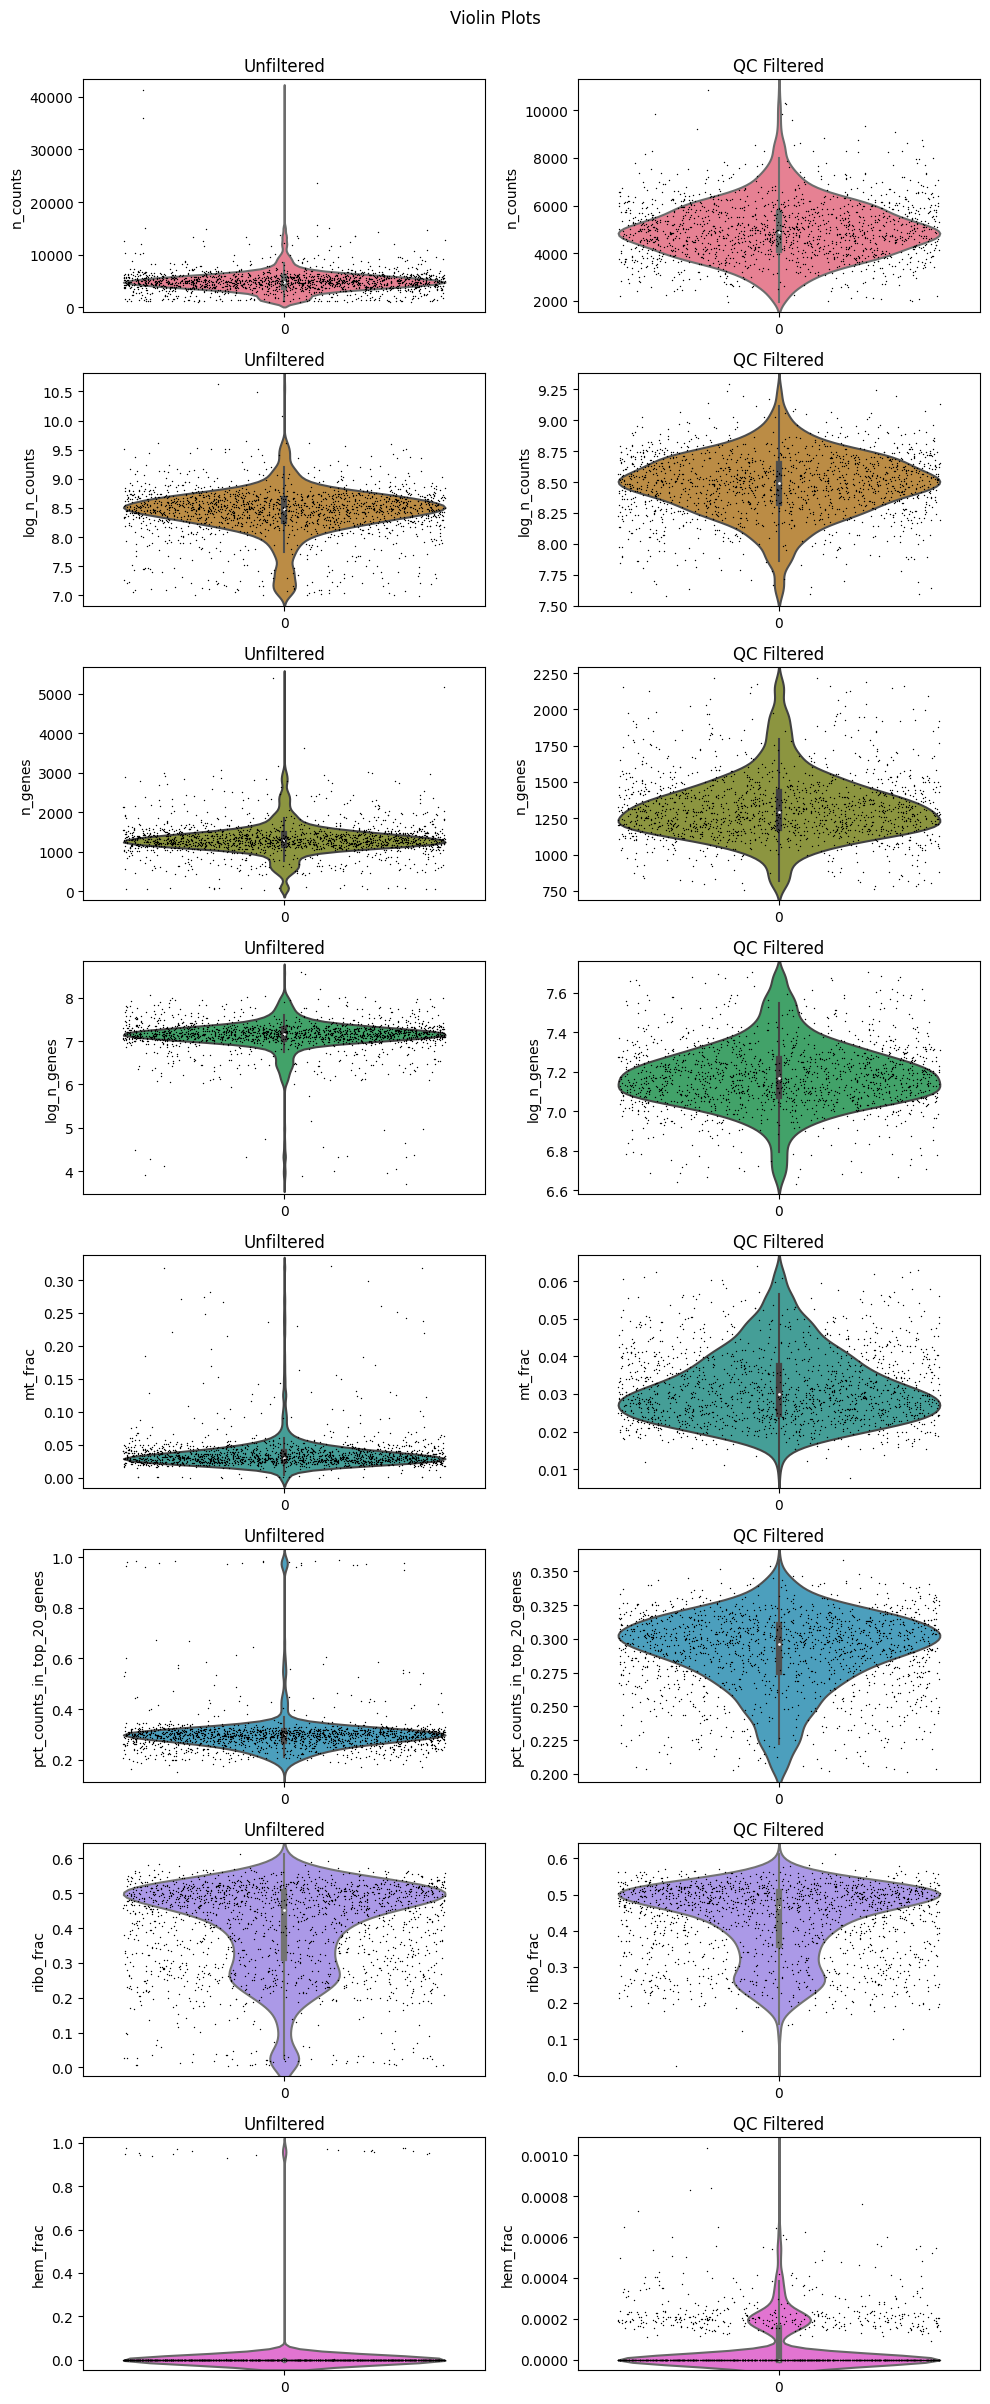

In [7]:
dp.EDA().ViolinJitter([adata, qc_adata], 
                        y_rows=['n_counts','log_n_counts','n_genes','log_n_genes','mt_frac','pct_counts_in_top_20_genes','ribo_frac','hem_frac'], 
                        title="Violin Plots",
                        subtitle=["Unfiltered", "QC Filtered"])

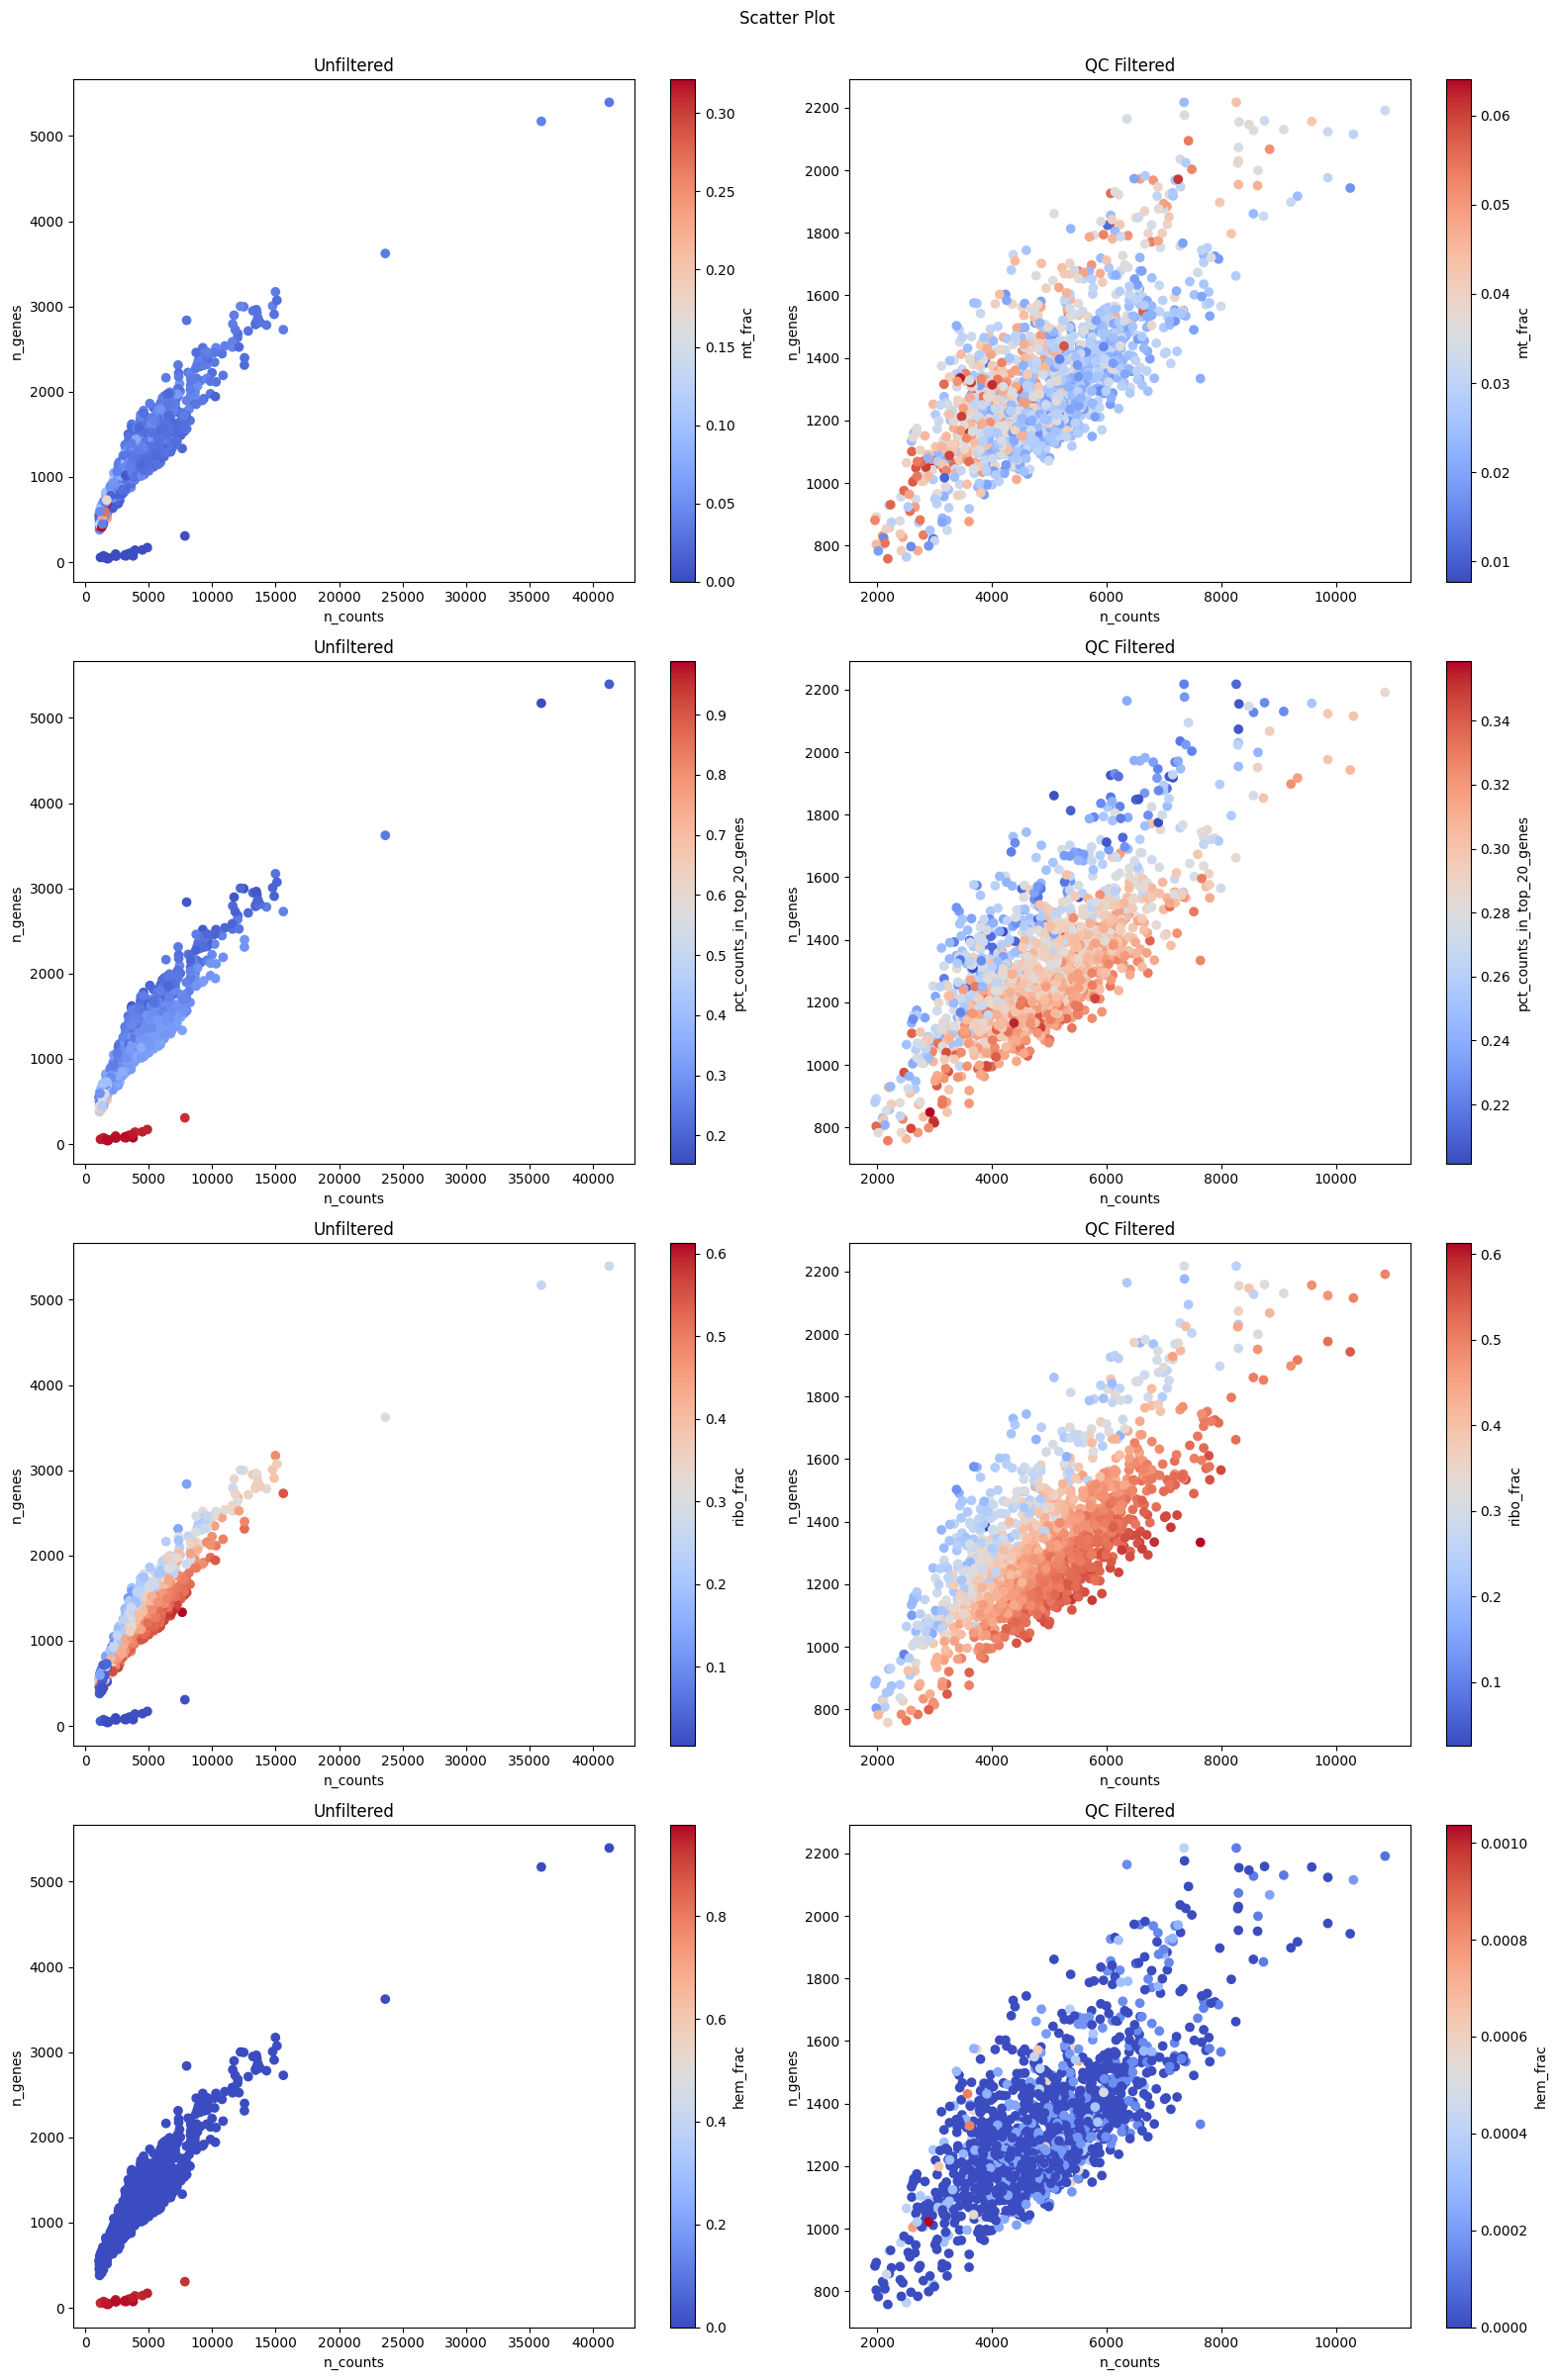

In [8]:
dp.EDA().ScatterForQCMetrics([adata, qc_adata],
                            title="Scatter Plot",
                            subtitle=["Unfiltered", "QC Filtered"])

## Normalize

In [9]:
norm_qc_adata = dp.log1p_normalize(qc_adata)

In [10]:
norm_qc_adata

AnnData object with n_obs × n_vars = 1553 × 9966
    obs: 'n_counts', 'log_n_counts', 'n_genes', 'log_n_genes', 'pct_counts_in_top_20_genes', 'mt_frac', 'ribo_frac', 'hem_frac', 'outlier', 'size_factors'
    var: 'gene_id', 'n_cells'
    layers: 'pp_counts', 'log1p_counts'

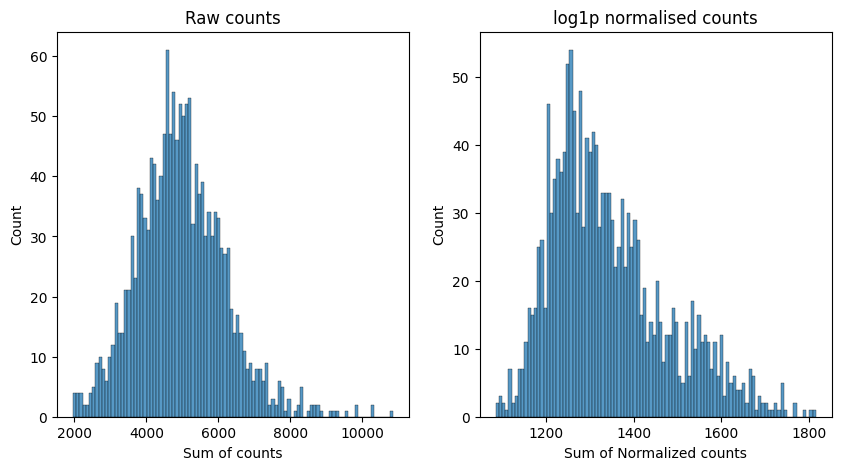

In [11]:
# Visualize counts before and after normalization
dp.EDA().VisualizeNormalization(norm_qc_adata)

In [12]:
# Download normalized count matrix
sc.pp.highly_variable_genes(norm_qc_adata, n_top_genes=4000, flavor="cell_ranger")
HVG_data = norm_qc_adata[:, norm_qc_adata.var["highly_variable"]]
normalized_counts = pd.DataFrame(HVG_data.layers["log1p_counts"])
normalized_counts.index = HVG_data.obs.index.to_list()
normalized_counts.columns = HVG_data.var.index.to_list()
normalized_counts.to_csv("PBMCs_2.csv")
norm_qc_adata.write("PBMCs_2_adata.h5ad")